In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/black-friday-sales-prediction/sample_submission_V9Inaty.csv
/kaggle/input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv
/kaggle/input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 17.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824024 sha256=a39adc9066ff8c1505cacbd1884bf4061e9a281d6d597cb8e752f2df24f60301
  Stored in directory: /root/.cache/pip/wheels/07/fb/67/b9f2c0242d156eaa136b45ae4fd99d3e7c0ecc2acfd26f47b9
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [4]:
import pyspark
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,mean,avg,max
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import DataFrame
from pyspark.ml.feature import Imputer

In [5]:
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/21 11:59:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
df = spark.read.csv("/kaggle/input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv",header=True,inferSchema =True)

In [7]:
df.columns

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Purchase']

In [8]:
df.count()

550068

In [9]:
df.show(5)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|1000001| P00069042|     F|0-17|        10|            A|                         2|             0|                 3|              null|              null|    8370|
|1000001| P00248942|     F|0-17|        10|            A|                         2|             0|                 1|                 6|                14|   15200|
|1000001| P00087842|     F|0-17|        10|            A|                         2|             0|                12|              null|              null|    1422|
|100

In [10]:
null_cols = {col:df.filter(df[col].isNull()).count() for col in df.columns}
null_cols

{'User_ID': 0,
 'Product_ID': 0,
 'Gender': 0,
 'Age': 0,
 'Occupation': 0,
 'City_Category': 0,
 'Stay_In_Current_City_Years': 0,
 'Marital_Status': 0,
 'Product_Category_1': 0,
 'Product_Category_2': 173638,
 'Product_Category_3': 383247,
 'Purchase': 0}

In [11]:
df = df.drop('User_ID','Product_ID','Occupation','Product_Category_3')
df.columns

['Gender',
 'Age',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Purchase']

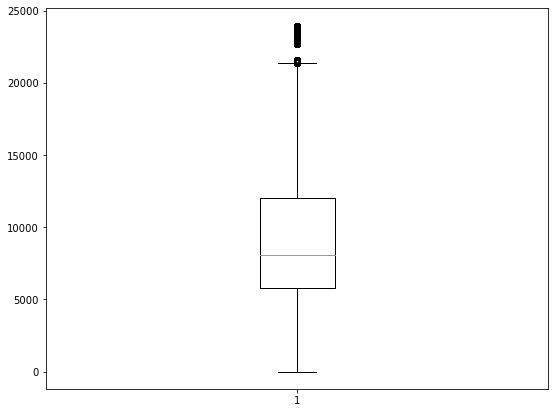

In [12]:
import matplotlib.pyplot as plt
x =df.select('Purchase').toPandas()
fig = plt.figure(figsize =(9, 7))
# Creating plot
plt.boxplot(x)
# show plot
plt.show()

In [13]:
#statistics for price
df.describe('Purchase').show()

+-------+-----------------+
|summary|         Purchase|
+-------+-----------------+
|  count|           550068|
|   mean|9263.968712959126|
| stddev|5023.065393820554|
|    min|               12|
|    max|            23961|
+-------+-----------------+



In [14]:
import pyspark.sql.functions as F

qtr_map = df.select(F.expr("percentile_approx(Purchase, 0.25) as Q1"),F.expr("percentile_approx(Purchase, 0.75) as Q3") \
             ).collect()[0].asDict()

df = df.filter((F.col("Purchase") >= qtr_map["Q1"]) & (F.col("Purchase") <= qtr_map["Q3"]))


In [15]:
class SmartEncoder():
    
    use_onehot = False 
    use_std_scaler = False
    cols_to_drop = None
    def __init__(self, df1, pred, use_onehot, use_std_scaler):
        print("Constructor of Class smartencoder ")

        self.df1 = df1
        self.pred = pred
        self.use_onehot = use_onehot
        self.use_std_scaler = use_std_scaler
        
    @staticmethod    
    def checkNulls(df):
        null_cols = {col:df.filter(df[col].isNull()).count() for col in df.columns}
        return null_cols
        
    
    def handlingMissingVal(self):
        #drop cols when the whole row is null
        df= self.df1.na.drop(how = "all")
        #Treating missing values
        self.cols_to_drop = [x for x in df.columns if df.filter(df[x].isNull()).count()>0]
        if len(self.cols_to_drop) != 0:
            dff=df.select(self.cols_to_drop)
            continuousCols =[item[0] for item in dff.dtypes if item[1] != 'string']
            imputer = Imputer(inputCols=continuousCols, outputCols=continuousCols).setStrategy("mean")
            model = imputer.fit(df)
            imputed_data = model.transform(df)
    
        else:
            imputed_data = df
            
        return imputed_data
    
    def dataPreprocess(self):
        
        #index the string to numeric
        self.stringCols = [item[0] for item in self.handlingMissingVal().dtypes if item[1] == 'string']
        if len(self.stringCols) != 0:   
            outputs=[]
            for tup in self.stringCols:
                outputs.append(tup + '_encoded')
    
            stringIndexer = StringIndexer(inputCols=self.stringCols, outputCols=outputs)
            model = stringIndexer.fit(self.handlingMissingVal())
            result = model.transform(self.handlingMissingVal())
    
            encoded = result.drop(*self.stringCols)
        
            if self.use_onehot == True:
                #converting categorical attributes into a binary vector
                vect=[]
                for tup in self.stringCols:
                    vect.append(tup + '_vec')
                encoder = OneHotEncoder(dropLast=False, inputCols=outputs, outputCols=vect)
                encoded2 = encoder.fit(encoded).transform(encoded)
    
                encoded = encoded2.drop(*outputs)
        else:
            encoded = self.handlingMissingVal()
        
        # VectorAssembler - tranform features into a feature vector column
        assembler = VectorAssembler(inputCols = encoded.drop(self.pred).columns, outputCol = 'features')
        df_Assembled = assembler.transform(encoded)
        
        if self.use_std_scaler == True:
            # standardize the dataframe to ensure that all the variables are around the same scale
            scale=StandardScaler(inputCol='features',outputCol='standardized')
            df_scale=scale.fit(df_Assembled)
            df_Assembled=df_scale.transform(df_Assembled)
            
        return df_Assembled
    
    

In [16]:
obj = SmartEncoder(df,'Purchase',False,True)

Constructor of Class smartencoder 


In [17]:
scaled_df = obj.dataPreprocess()
scaled_df.columns

['Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Purchase',
 'Gender_encoded',
 'Age_encoded',
 'City_Category_encoded',
 'Stay_In_Current_City_Years_encoded',
 'features',
 'standardized']

In [18]:
SmartEncoder.checkNulls(scaled_df)

{'Marital_Status': 0,
 'Product_Category_1': 0,
 'Product_Category_2': 0,
 'Purchase': 0,
 'Gender_encoded': 0,
 'Age_encoded': 0,
 'City_Category_encoded': 0,
 'Stay_In_Current_City_Years_encoded': 0,
 'features': 0,
 'standardized': 0}

In [19]:
finalized_data = scaled_df.select("standardized","Purchase")
finalized_data.show(5)

+--------------------+--------+
|        standardized|Purchase|
+--------------------+--------+
|[0.0,0.9955600491...|    8370|
|[0.0,2.6548267978...|    7969|
|[2.03111960209866...|    7871|
|[2.03111960209866...|    6073|
|[0.0,1.6592667486...|    8851|
+--------------------+--------+
only showing top 5 rows



In [20]:
#Randomly split data into training and test sets
trainDF, testDF = finalized_data.randomSplit([0.8, 0.2], seed=42)

In [21]:
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())
trainDF.show(5)

219908


55132
+--------------------+--------+
|        standardized|Purchase|
+--------------------+--------+
|(7,[0,1,2],[2.031...|    7617|
|(7,[0,1,2],[2.031...|    7662|
|(7,[0,1,2],[2.031...|    7709|
|(7,[0,1,2],[2.031...|    7712|
|(7,[0,1,2],[2.031...|    7713|
+--------------------+--------+
only showing top 5 rows



In [22]:
#Import Linear Regression class called LinearRegression
from pyspark.ml.regression import LinearRegression
LinReg = LinearRegression(featuresCol="standardized", labelCol="Purchase", maxIter=10, regParam=1.0)
#Train the model on the training using fit() method.
model = LinReg.fit(trainDF)

In [23]:
# Coefficients for the model
model.coefficients

DenseVector([10.1478, -790.7033, -88.2614, -28.505, 31.3342, -2.7818, -2.48])

In [24]:
# Intercept for the model
model.intercept

10102.261278338809

In [25]:
# Get the RMSE
print("RMSE: {0}".format(model.summary.rootMeanSquaredError))

RMSE: 1539.6826684609582


In [26]:
# Get the R2
print("R2: {0}".format(model.summary.r2))

R2: 0.22780031230759967


In [27]:
## Make predictions on test data using the transform() method
predDF = model.transform(testDF)
predDF.printSchema()

root
 |-- standardized: vector (nullable = true)
 |-- Purchase: integer (nullable = true)
 |-- prediction: double (nullable = false)



In [28]:
predDF.select("Purchase", "prediction").show()

+--------+-----------------+
|Purchase|       prediction|
+--------+-----------------+
|    7670|9816.450045428419|
|    7720|9816.450045428419|
|    7753|9816.450045428419|
|    7897|9816.450045428419|
|    8005|9816.450045428419|
|    8028|9816.450045428419|
|    8170|9816.450045428419|
|    8224|9816.450045428419|
|    8338|9816.450045428419|
|   11372|9816.450045428419|
|   11375|9816.450045428419|
|   11396|9816.450045428419|
|   11423|9816.450045428419|
|   11470|9816.450045428419|
|   11543|9816.450045428419|
|   11629|9816.450045428419|
|   11715|9816.450045428419|
|   11994|9816.450045428419|
|    7882|9750.412548139042|
|    8078|9750.412548139042|
+--------+-----------------+
only showing top 20 rows



In [29]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Purchase')
r2 = evaluator.evaluate(predDF,{evaluator.metricName: "r2"})
print("R2: ",r2)

R2:  0.22510921579652754


In [30]:
rmse = evaluator.evaluate(predDF, {evaluator.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

RMSE: 1540.967


In [32]:
#Import Randomforest Regression class called RandomForestRegression
from pyspark.ml.regression import LinearRegression,RandomForestRegressor,DecisionTreeRegressor
rf = RandomForestRegressor(labelCol="Purchase", featuresCol="standardized")
model2 = rf.fit(trainDF)
predRf = model2.transform(testDF)

In [ ]:
predRf.show(5)

In [ ]:
r2 = evaluator.evaluate(predRf,{evaluator.metricName: "r2"})
print("R2: ",r2)

In [34]:
from pyspark.ml.regression import LinearRegression,RandomForestRegressor,DecisionTreeRegressor,GBTRegressor

class RegEval():

    def __init__(self,pred,final_df):
        print("Constructor of class for regression evaluation ")
        self.final_df = final_df
        self.pred = pred
        self.rmse ={}
        self.r2={}
        self.mse = {}
        
    def run_on_model(self,model,featureCol):
        trainDF, testDF = self.final_df.randomSplit([0.7, 0.3], seed=42)
        if model == 'lr':
            lr = LinearRegression(featuresCol=featureCol, labelCol=self.pred, maxIter=10, regParam=1.0)
            modellr = lr.fit(trainDF)
            self.predlr = modellr.transform(testDF)
            return self.predlr
        elif model == 'rf':
            rf = RandomForestRegressor(labelCol=self.pred, featuresCol=featureCol)
            modelrf = rf.fit(trainDF)
            self.predrf = modelrf.transform(testDF)
            return self.predrf
        elif model == 'dt':
            dt = DecisionTreeRegressor(labelCol=self.pred, featuresCol=featureCol)
            modeldt = dt.fit(trainDF)
            self.preddt = modeldt.transform(testDF)
            return self.preddt
        elif model == 'gb':
            gb = GBTRegressor(labelCol=self.pred, featuresCol=featureCol,maxIter=10)
            modelgb = gb.fit(trainDF)
            self.predgb = modelgb.transform(testDF)
            return self.predgb
        else:
            raise ValueError('invalid model')
             

              
    def genMetrics(self,model,featureCol):
        pred_test = self.run_on_model(model,featureCol)
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=self.pred)
        self.r2[model] = evaluator.evaluate(pred_test,{evaluator.metricName: "r2"})
        self.rmse[model] = evaluator.evaluate(pred_test, {evaluator.metricName: "rmse"})
        self.mse[model] = evaluator.evaluate(pred_test, {evaluator.metricName: "mse"})
      
       
       
    def run_all_model(self,featureCol):
        models = ['lr','rf','dt','gb']
        for model in models:
            self.genMetrics(model, featureCol)
        print("R2: ",self.r2)
        print("RMSE:" ,self.rmse)
        print("MSE:" ,self.mse)
        return self.r2, self.rmse, self.mse
        
    def compareModel(self):
        best_v =0
        best_k=None
        for k,v in self.r2.items():
            if best_v < v:
                best_v=v
                best_k=k
        return best_k,best_v, 
        

In [35]:
obj2 = RegEval('Purchase',finalized_data)

Constructor of class for regression evaluation 


In [36]:
a,b,c = obj2.run_all_model("standardized")

R2:  {'lr': 0.22599115115331325, 'rf': 0.39660133663092423, 'dt': 0.41687387112365404, 'gb': 0.42097036746426175}
RMSE: {'lr': 1540.4723734429574, 'rf': 1360.1384664080215, 'dt': 1337.0948072987317, 'gb': 1332.3899437830414}
MSE: {'lr': 2373055.1333409785, 'rf': 1849976.6478027643, 'dt': 1787822.5237052327, 'gb': 1775262.9622941755}


In [37]:
obj2.compareModel()

('gb', 0.42097036746426175)

In [40]:
trainDF, testDF = finalized_data.randomSplit([0.7, 0.3], seed=42)
gb = GBTRegressor(labelCol="Purchase", featuresCol="standardized")
gbevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Purchase", metricName="r2")

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 10])
             .addGrid(gb.maxBins, [10, 20, 40])
             .addGrid(gb.maxIter, [5, 10, 20])
             .build())

cv = gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 5, parallelism=5)

# Run cross validations.  
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(trainDF)
cvPreds = cvModel.transform(testDF)
gbtEval.evaluate(cvPreds)